## 1. Carga de datos

In [279]:
import numpy  as np  
import pandas as pd

In [280]:
import warnings
warnings.filterwarnings('ignore')

In [449]:
#Cargo fichero
raw_data = pd.read_csv("airbnb-listings-extract.csv", sep=';')
print(raw_data.shape)
raw_data.head(5).T  #datos en bruto

(14780, 89)


,0,1,2,3,4
ID,11210388,17471131,17584891,5398030,18104606
Listing Url,https://www.airbnb.com/rooms/11210388,https://www.airbnb.com/rooms/17471131,https://www.airbnb.com/rooms/17584891,https://www.airbnb.com/rooms/5398030,https://www.airbnb.com/rooms/18104606
Scrape ID,20170306202425,20170407214050,20170407214050,20170407214050,20170407214050
Last Scraped,2017-03-07,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,The Loft-Full Bath-Deck w/View,"Claris I, Friendly Rentals","Style Terrace Red, Friendly Rentals",Picasso Suite 1.4 Paseo de Gracia,Smart City Centre Apartment II
...,...,...,...,...,...
Cancellation Policy,moderate,super_strict_30,super_strict_30,strict,flexible
Calculated host listings count,1.0,106.0,106.0,24.0,92.0
Reviews per Month,3.5,0.86,NaN,1.09,NaN
Geolocation,"30.3373609355,-97.8632766782","41.3896829422,2.17262543017","41.3930345489,2.16217327868","41.3969668101,2.1674178103","41.3886851936,2.15514963616"


#### Filtro y me quedo sólo con los datos correspondientes a Madrid.

In [450]:
# Análisis de España
total_filas = len(raw_data)
spain_count = raw_data[raw_data['Country'] == 'Spain'].shape[0]
spain_percentage = (spain_count / total_filas) * 100

print(f"Total dataset: {total_filas:,} propiedades")
print(f"Total España: {spain_count:,} propiedades ({spain_percentage:.2f}%)")

Total dataset: 14,780 propiedades
Total España: 14,001 propiedades (94.73%)


In [451]:
# Análisis de Madrid 
total_filas = len(raw_data)

# Buscar en Madrid
madrid_filter = raw_data['City'].str.contains('madrid', case=False, na=False)
madrid_count = madrid_filter.sum()
madrid_percentage = (madrid_count / total_filas) * 100

# Buscar otras ciudades de la Comunidad de Madrid
ciudades_madrid = [
    'pozuelo', 'alcalá', 'alcala', 'getafe', 'leganés', 'leganes', 'fuenlabrada', 
    'alcorcón', 'alcorcon', 'móstoles', 'mostoles', 'torrejón', 'torrejon',
    'parla', 'alcobendas', 'aranjuez', 'coslada', 'las rozas', 'majadahonda',
    'rivas', 'collado villalba', 'boadilla', 'san sebastián de los reyes',
    'san sebastian de los reyes', 'tres cantos', 'valdemoro', 'pinto',
    'arganda', 'chinchón', 'chinchon', 'navalcarnero', 'colmenar viejo'
]

otras_madrid_filter = raw_data['City'].str.contains('|'.join(ciudades_madrid), case=False, na=False) & ~madrid_filter
otras_madrid_count = otras_madrid_filter.sum()
otras_madrid_percentage = (otras_madrid_count / total_filas) * 100

# Total Comunidad de Madrid
total_madrid_count = madrid_count + otras_madrid_count
total_madrid_percentage = (total_madrid_count / total_filas) * 100

print(f"Total dataset: {total_filas:,} propiedades")
print(f"Total Madrid: {total_madrid_count:,} propiedades ({total_madrid_percentage:.2f}%)")

Total dataset: 14,780 propiedades
Total Madrid: 13,252 propiedades (89.66%)


Elegir Madrid supone perder cerca de un 11% de datos, lo cual es bastante dado el tamaño del dataset. Pero elegir como muestra España (y perder sólo 5%) puede estar metiendo más variabilidad al modelo para Madrid si los precios entre comunidades son muy diferentes y no habría suficiente muestra representativa del resto de ciudades

In [452]:
# Filtro Madrid
total_madrid_filter = madrid_filter | otras_madrid_filter

# Creo copia filtrada por Madrid 
raw_data_madrid = raw_data[total_madrid_filter].copy() #sólo madrid 

print(f"Dataset original: {raw_data.shape}")
print(f"Dataset Madrid: {raw_data_madrid.shape}")
print(f"Registros eliminados: {len(raw_data) - len(raw_data_madrid):,}")

Dataset original: (14780, 89)
Dataset Madrid: (13252, 89)
Registros eliminados: 1,528


#### Elimino variables no relevantes para caso estudio ya que no voy a hacer procesamiento de texto (Url's, Id's, descripciones y metadata). 
Además elimino las columnas `City`, `Country` por seleccionar sólo Madrid

In [453]:
# una copia de los datos para trabajar 
data_madrid= raw_data_madrid.copy()

columns_to_drop = [
    'ID', 'Listing Url', 'Scrape ID', 'Thumbnail Url', 'Medium Url', 
    'Picture Url', 'XL Picture Url', 'Host URL', 'Host Thumbnail Url', 
    'Host Picture Url', 'Last Scraped', 'Name', 'Summary', 'Space', 
    'Description', 'Neighborhood Overview', 'License', 'Jurisdiction Names', 
    'Cancellation Policy', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 'Host ID', 'Host Name', 
    'Host Location', 'Host About', 'Host Response Time', 'Geolocation', 'Smart Location', 'Market', 'Street', 
    'Host Verifications', 'Neighbourhood', 'Neighbourhood Cleansed', 'State',
    'Neighbourhood Group Cleansed', 'Country Code', 'Calendar Updated', 'City', 'Country',
    'Calendar last Scraped', 'Features', 'Host Neighbourhood'
]

input_madrid= data_madrid.drop(columns=columns_to_drop)  # Aplico la eliminación de variables

print(f"Dataset original: {raw_data.shape}")
print(f"Dataset después de limpieza: {input_madrid.shape}")
input_madrid.head(5).T #sólo madrid sin columnas texto

Dataset original: (14780, 89)
Dataset después de limpieza: (13252, 44)


,40,41,42,43,44
Experiences Offered,none,none,none,none,none
Host Since,2015-01-06,2015-01-01,2016-04-18,2012-09-08,2013-12-25
Host Response Rate,84.0,100.0,100.0,100.0,100.0
Host Acceptance Rate,NaN,NaN,NaN,NaN,NaN
Host Listings Count,3.0,1.0,2.0,8.0,2.0
Host Total Listings Count,3.0,1.0,2.0,8.0,2.0
Zipcode,28007,28001,28001,28001,28001
Latitude,40.406953,40.425904,40.428352,40.427454,40.428671
Longitude,-3.670894,-3.681647,-3.687155,-3.685763,-3.685423
Property Type,Apartment,Apartment,Apartment,Apartment,Apartment


## 2. División de datos Train / Test
#### Aplico método `train_test_split` para separación fisica en dos archivos .csv (datos de entrenamiento y prueba)

In [454]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(input_madrid, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('airbnb-listings-extract-train.csv', sep=';', decimal='.', index=False)
test.to_csv('airbnb-listings-extract-test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (10601, 44)
Dimensiones del dataset de test: (2651, 44)


In [455]:
# Trabajo sólo con el dataset de train

pretrain_data = pd.read_csv('airbnb-listings-extract-train.csv', sep=';', decimal='.') #Train de sólo madrid sin columnas texto
pretrain_data.head(5).T

,0,1,2,3,4
Experiences Offered,none,none,none,none,none
Host Since,2013-01-22,2016-01-29,2014-07-26,2016-06-08,2014-03-06
Host Response Rate,100.0,100.0,100.0,80.0,100.0
Host Acceptance Rate,NaN,NaN,NaN,NaN,NaN
Host Listings Count,2.0,4.0,1.0,1.0,2.0
Host Total Listings Count,2.0,4.0,1.0,1.0,2.0
Zipcode,28015,28028,28005,28032,28004
Latitude,40.424541,40.435688,40.413167,40.407085,40.420483
Longitude,-3.711495,-3.671686,-3.708769,-3.607053,-3.703334
Property Type,Apartment,Apartment,Apartment,Bed & Breakfast,Apartment


## 3. Análisis exploratorio

#### Miro los datos de Train para saber distribuciones estadisticas, outliers, correlaciones.
- VAR númericas Vs categoricas
- Info, describe...
- Histogramas, scatterplots..
- (Matriz correlaciones entre variables)
- (Método de filtrado: `f_reg, mutual_info_reg`)

In [283]:
# Clasificación de variables: Numéricas vs Categóricas
numerical_var = pretrain_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_var = pretrain_data.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"{len(pretrain_data.columns)} variables total | {len(numerical_var)} numéricas | {len(categorical_var)} categóricas")

44 variables total | 35 numéricas | 9 categóricas


In [ ]:
pretrain_data.describe().T

Aqui podemos ver de primeras que variables como `Host Response Rate`, `Has Availability` tienen todos los valores nulos. `Square feet` que a priori que puede parecer una variable interesante tiene muy pocos datos. Hay bastantes variables como `price`, `monthly price`que tienen outliers significativos que convendria filtrar (viendo los valores máximos). `maximum night`tiene una muy alta desviación standar.

In [ ]:
pretrain_data.info()

In [203]:
from ydata_profiling import ProfileReport

profile = ProfileReport(pretrain_data, title="Profiling Report")

In [ ]:
profile.to_file("your_report.html")

### 3.1 Análisis exploratorio - Variables numericas

In [456]:
# Variables NUMÉRICAS
numerical_data = []
numerical_var = pretrain_data.select_dtypes(include=[np.number]).columns.tolist()
for col in numerical_var:
    null_pct = (pretrain_data[col].isnull().sum() / len(pretrain_data)) * 100
    numerical_data.append({
        'Variable': col,
        'Dtype': str(pretrain_data[col].dtype),
        'Valores_únicos': pretrain_data[col].nunique(),
        'Nulos_%': round(null_pct, 2),
    })

numerical_df = pd.DataFrame(numerical_data)
display(numerical_df)

,Variable,Dtype,Valores_únicos,Nulos_%
0,Host Response Rate,float64,67,12.55
1,Host Acceptance Rate,float64,0,100.00
2,Host Listings Count,float64,47,0.02
3,Host Total Listings Count,float64,47,0.02
4,Latitude,float64,10601,0.00
5,Longitude,float64,10601,0.00
6,Accommodates,int64,15,0.00
7,Bathrooms,float64,16,0.36
8,Bedrooms,float64,10,0.13
9,Beds,float64,16,0.36


#### `Price`

La primera variable que vamos a revisar es `price` por ser la variable objetivo:

Percentil 99: 295.28


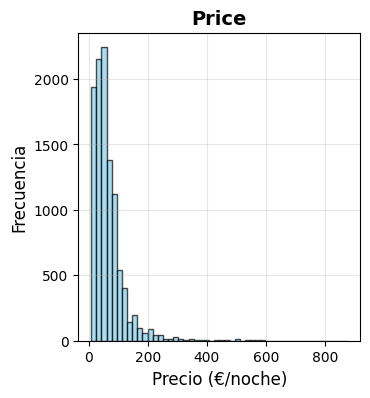

In [457]:
# Histograma de la variable Price
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.hist(pretrain_data['Price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Precio (€/noche)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Price', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

print(f"Percentil 99: {pretrain_data['Price'].quantile(0.99):.2f}")

In [458]:
print(f"Valore nulos en 'price' ANTES: {pretrain_data['Price'].isnull().sum()}")

Valore nulos en 'price' ANTES: 7


- Hay valores nulos que habrá que eliminar
- Hay outliers que conviene filtrar (hasta 300€/noche cubre el 99% de las muestras)
- Se ve una distribución muy escorda hacia la izquierda, conviene aplicar transformación (por ej. logaritmica) para ver si se centra más a una distribución normal. 

#### `Listing Count`

`Host listings count`, `Host total listings count`, `Calculated Host Listings count`parecen tener la misma informacion, colineales (esto lo confirmamos más adelante en la matriz de correlacion), habría que quedarse con una y tratarla con trasnformacion logaritmica 

#### `Latitude`, `Longitude`

`Latitude`, `Longitude` las dejo como están. No hay nulos. Buena distribución normal

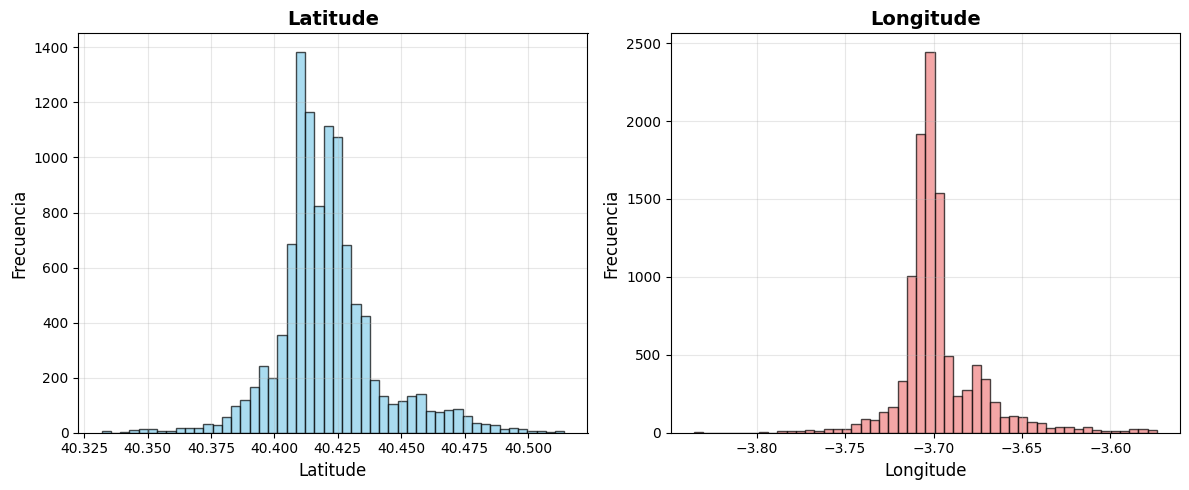

In [460]:
plt.figure(figsize=(12, 5))

# Latitude
plt.subplot(1, 2, 1)
plt.hist(pretrain_data['Latitude'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Latitude', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Longitude
plt.subplot(1, 2, 2)
plt.hist(pretrain_data['Longitude'].dropna(), bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Longitude', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

#### `Accommodates`, `Beds`, `Bedrooms` tienen una alta correlacion (parece que tiene sentido que el alojamiento este relacionado con el num de camas y dormitorios). Ver matriz de correlación. Quizá podamos descartar alguna en pro de las otras por ej. `Beds` en vista de los scatter plots

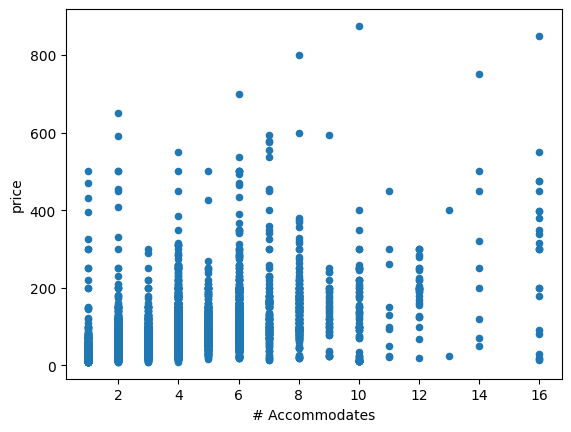

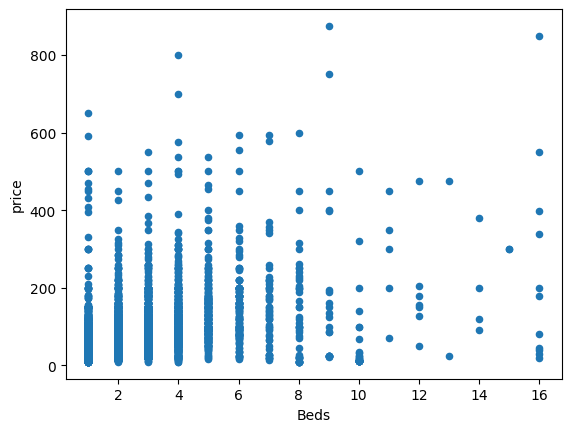

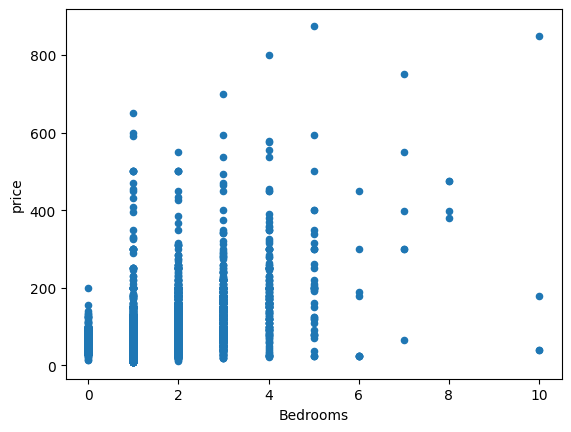

In [462]:
pretrain_data.plot(kind = 'scatter',x='Accommodates',y = 'Price')
plt.xlabel('# Accommodates')
plt.ylabel('price')
plt.show()

pretrain_data.plot(kind = 'scatter',x='Beds',y = 'Price')
plt.xlabel('Beds')
plt.ylabel('price')
plt.show()

pretrain_data.plot(kind = 'scatter',x='Bedrooms',y = 'Price')
plt.xlabel('Bedrooms')
plt.ylabel('price')
plt.show()

#### `Square feet`, se descarta por alto %valores nulos

In [463]:
print(f"Valore nulos en 'square feet': {pretrain_data['Square Feet'].isnull().sum()}")

Valore nulos en 'square feet': 10185


#### `Weekly Price`, `Monthly Price` se descarta por alto %valores nulos (>75%) y por alta correlación (Aunque no lineal) con la variable objetivo (ver matriz más adelante). Además estas variables pueden añadir confusión al modelo por interpretación errónea (Exactamente weekly price no es el precio/noche*7, ni monthly *31)

In [465]:
print(f"Valore nulos en 'Weekly Price': {pretrain_data['Weekly Price'].isnull().sum()}")
print(f"Valore nulos en 'Monthly Price': {pretrain_data['Monthly Price'].isnull().sum()}")

Valore nulos en 'Weekly Price': 7904
Valore nulos en 'Monthly Price': 7951


#### `Security Deposit`, `Cleaning Fee` tienen bastantes valores nulos lo cual indica que probablemente sea porque no apliquen (Es decir el valor sea 0). Además ambas variables están muy escoradas por lo que también conviene mejorar la distribución con una transformación logaritmica. 

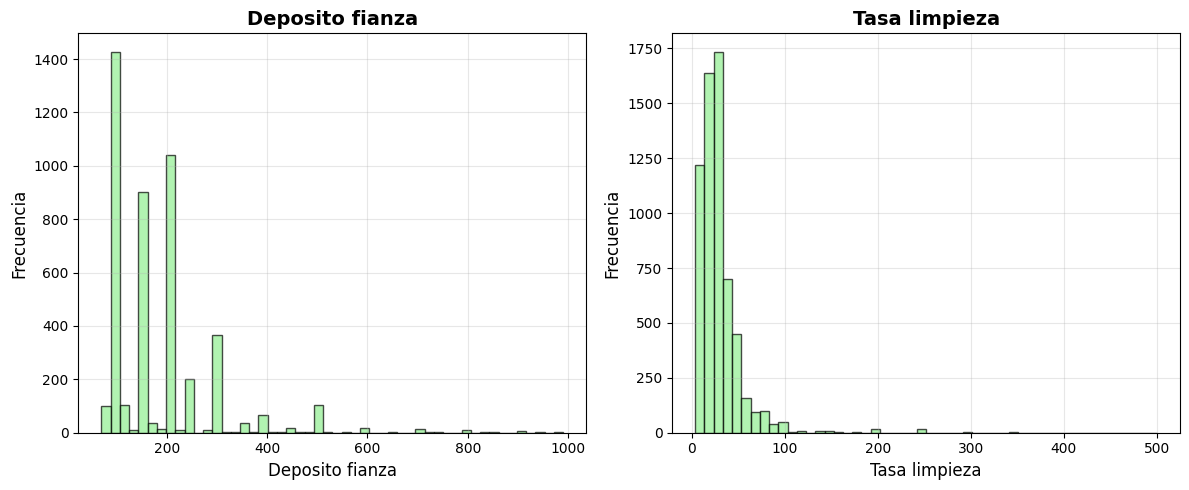

In [466]:
plt.figure(figsize=(12, 5))

# Seecurity Deposit
plt.subplot(1, 2, 1)
plt.hist(pretrain_data['Security Deposit'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Deposito fianza', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Deposito fianza', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Claening fee
plt.subplot(1, 2, 2)
plt.hist(pretrain_data['Cleaning Fee'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Tasa limpieza', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Tasa limpieza', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### `Extra People`, `Reviews Per Month` tienen valores nulos que ha de tratarse como 0 (no hay extracoste, no hay revisiones mensuales) Aplicamos transformación log.

#### `Minimum Nights` Aplicamos también transformación log pero no filtramos outliers ya que podría haber anfitriones que requieran un minimo de estancia y esto afecte siginificativamente en el precio (y sea útil)

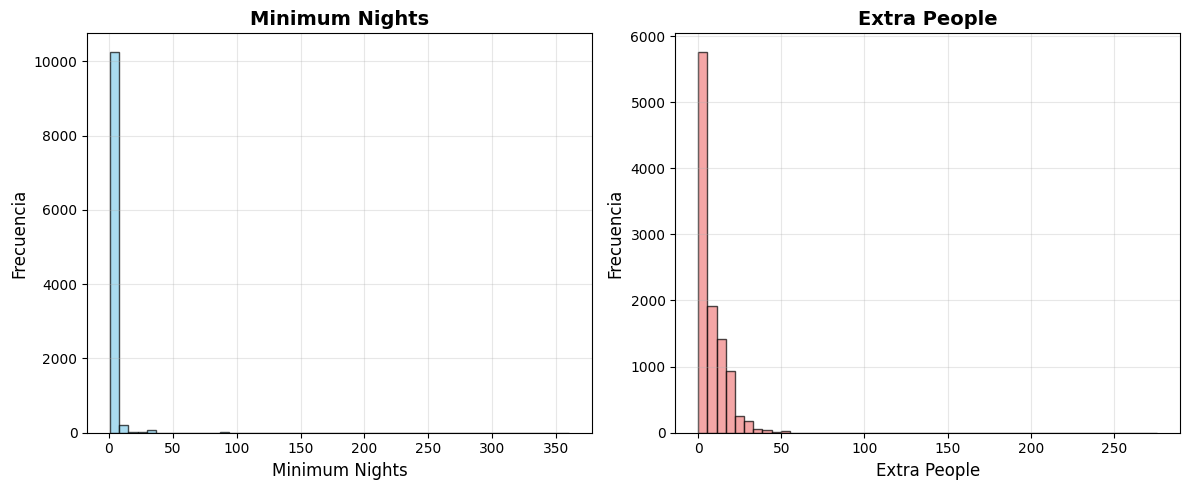

In [293]:
plt.figure(figsize=(12, 5))

# LOG(Extra People)
plt.subplot(1, 2, 2)
plt.hist(pretrain_data['Extra People'].dropna(), bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Extra People', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Extra People', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# LOG(Minimum Nights)
plt.subplot(1, 2, 1)
plt.hist(pretrain_data['Minimum Nights'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Minimum Nights', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Minimum Nights', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### `Availability 30, 60, 90, 365` contiene información redundante y están fuertemente correlacionadas entre si (ver matiz correlación). 

- Hago una nueva variable, tasa de ocupación `Booking Rate` = (365 - availability_365) / 365, y descarto el resto.

#### `Number of reviews` transformación logaritmica. 

- Resto de valoraciones: `Review Scores...` tienen similar cantidad de valores nulos, lo que puede traducirse en la misma propiedad que no tenga ningun tipo de reseña. Tienen mucho sesgo. Voy a imputar los nulos con la mediana y hacer una nueva variable, puntuación media `Avg Review Score`.

### 3.1.1 Matriz correlación

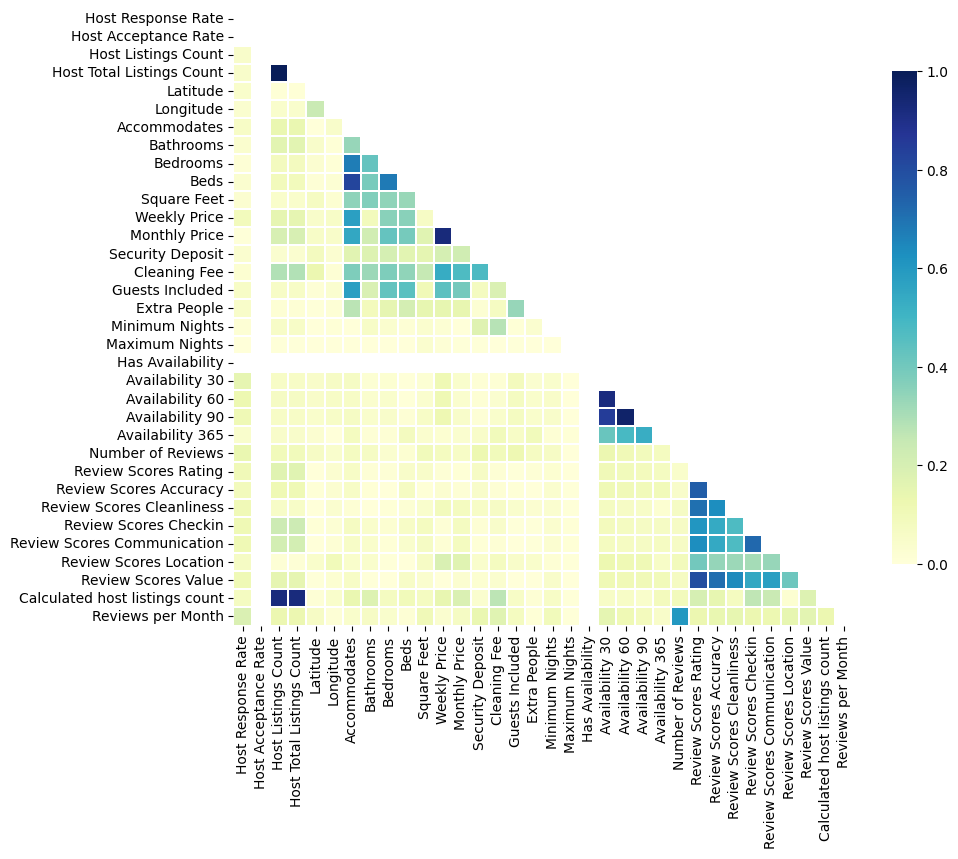

In [468]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(pretrain_data.drop(['Price'], axis=1).corr(numeric_only=True))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

### 3.1.2 Método de filtrado `f_regression`, `mutual_info_reg`

In [470]:
# Coloco Price en el índice 0 (primera columna, para facilitar analisis posterior)
price_col = pretrain_data['Price']
pretrain_data = pretrain_data.drop('Price', axis=1)
pretrain_data.insert(0, 'Price', price_col)


### 3.1.3 Resumen tratamiento variables numericas

| Atributo | descripción | conclusión |
|:---------|:------------|:-----------|
| *Price* | precio €/noche | Eliminar nulos, filtrar outliers y trasnformación log1p |
| *Host Acceptance Rate* | % solicitudes aceptadas por anfitrión | Eliminar por alto valor de nulos|
| *Host Response Rate* | % respuesta del anfitrión | Eliminar |
| *Host Listings Count* | nºprop del anfitrión | Imputar nulos con mediana y transformacion log1p |
| *Host Total Listings Count* | nºtotal prop del anfitrión | Eliminar por redundancia con Host Listings Count |
| *Latitude* | latitud | dejar|
| *Longitude* | longitud | dejar|
| *Accommodates* | capacidad de alojamiento | dejar|
| *Bathrooms* | nºbaños | imputar nulos con mediana, dejar 0 (baño compartido?¿)|
| *Bedrooms* | nºhabitaciones | imputar nulos con mediana, dejar 0 (casa diafana?¿), ver posible correlacion|
| *Bed* | nºcamas | ver posible correlacion|
| *Square feet* | m2 | Eliminar por alto valor de nulos|
| *Weekly Price* | precio €/semana | Eliminar por alto valor de nulos|
| *Monthly Price* | precio €/mes | Eliminar por alto valor de nulos|
| *Security Deposit* | fianza | Imputar nulos con 0 y transformación log1p |
| *Cleaning fee* | tas alimpieza | Imputar nulos con 0 y transformación log1p|
| *Guests Included* | nºHuesped incluido | dejar|
| *Extra People* | huesped extra | Imputar nulos con 0 y transformación log1p|
| *Minimum Nights* | minimo noches | transformación log1p|
| *Maximum Nights* | máximo noches | Eliminar alta desv. |
| *Has Availability* | disponibilidad actual | Eliminar por alto valor de nulos|
| *Availability 30* | disponibilidad 30 dias | Eliminar alta correlacion |
| *Availability 60* | disponibilidad 60 dias | Eliminar alta correlacion |
| *Availability 90* | disponibilidad 90 dias | Eliminar alta correlacion |
| *Availability 365* | disponibilidad 365 dias | Eliminar y crear nueva variable booking_rate |
| *Number of Reviews* | nºreseñas | transformación log1p|
| *Review Scores Rating* | rating puntuación | Eliminar|
| *Review Scores Accuracy* | puntuación precision | Eliminar|
| *Review Scores Cleanliness* | puntuación limpieza | Eliminar|
| *Review Scores Checkin* | puntuación Checkin | Eliminar|
| *Review Scores Communication* | puntuación comunicación | Eliminar|
| *Review Scores Location* | puntuación localización | Eliminar|
| *Review Scores Value* | valor puntuación | Eliminar y crear nueva variable con la media de reviews|
| *Calculated Host Listings Count* | nºcalculado prop del anfitrión | Eliminar por redundancia con Host Listings Count |
| *Reviews Per Month* | revisiones al mes | Imputar nulos con 0 y transformacion log1p |

### 3.2 Análisis exploratorio - Variables categórcias

In [299]:
# Variables CATEGÓRICAS
categorical_data = []
categorical_var = pretrain_data.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_var:
    null_pct = (pretrain_data[col].isnull().sum() / len(pretrain_data)) * 100
    categorical_data.append({
        'Variable': col,
        'Dtype': str(pretrain_data[col].dtype),
        'Valores_únicos': pretrain_data[col].nunique(),
        'Nulos_%': round(null_pct, 2),
    })

categorical_df = pd.DataFrame(categorical_data)
display(categorical_df)

,Variable,Dtype,Valores_únicos,Nulos_%
0,Experiences Offered,object,1,0.00
1,Host Since,object,1996,0.02
2,Zipcode,object,74,3.25
3,Property Type,object,22,0.00
4,Room Type,object,3,0.00
5,Bed Type,object,5,0.00
6,Amenities,object,9062,0.78
7,First Review,object,1510,20.60
8,Last Review,object,652,20.61


#### `Experiences Offered`, sólo tiene un valor único "NONE" , no aporta información ya que es un valor constante. Se puede eliminar

In [298]:
print(pretrain_data['Experiences Offered'].value_counts())

Experiences Offered
none    10601
Name: count, dtype: int64


#### `Host since`, propietarios más antiguos pueden dar informacion relevante sobre mejores o peores precios y dado que tiene casi el 100% de los datos vamos a transformarla en antiguedad como la diferencia con la fecha máx (7/04/2017)

#### `Propierty Type`, `Room Type`, `Bed Type` veamos valores únicos e histograma


ANÁLISIS DE PROPERTY TYPE
Valores únicos: 22

Distribución de frecuencias:
Property Type
Apartment             8762
House                  760
Condominium            283
Bed & Breakfast        270
Loft                   217
Other                  169
Dorm                    36
Guesthouse              29
Chalet                  21
Hostel                  15
Serviced apartment      10
Townhouse                8
Boutique hotel           5
Earth House              3
Guest suite              3
Villa                    3
Casa particular          2
Timeshare                1
Bungalow                 1
Boat                     1
Camper/RV                1
Tent                     1
Name: count, dtype: int64

--------------------------------------------------

ANÁLISIS DE ROOM TYPE
Valores únicos: 3

Distribución de frecuencias:
Room Type
Entire home/apt    6305
Private room       4133
Shared room         163
Name: count, dtype: int64

--------------------------------------------------

ANÁLIS

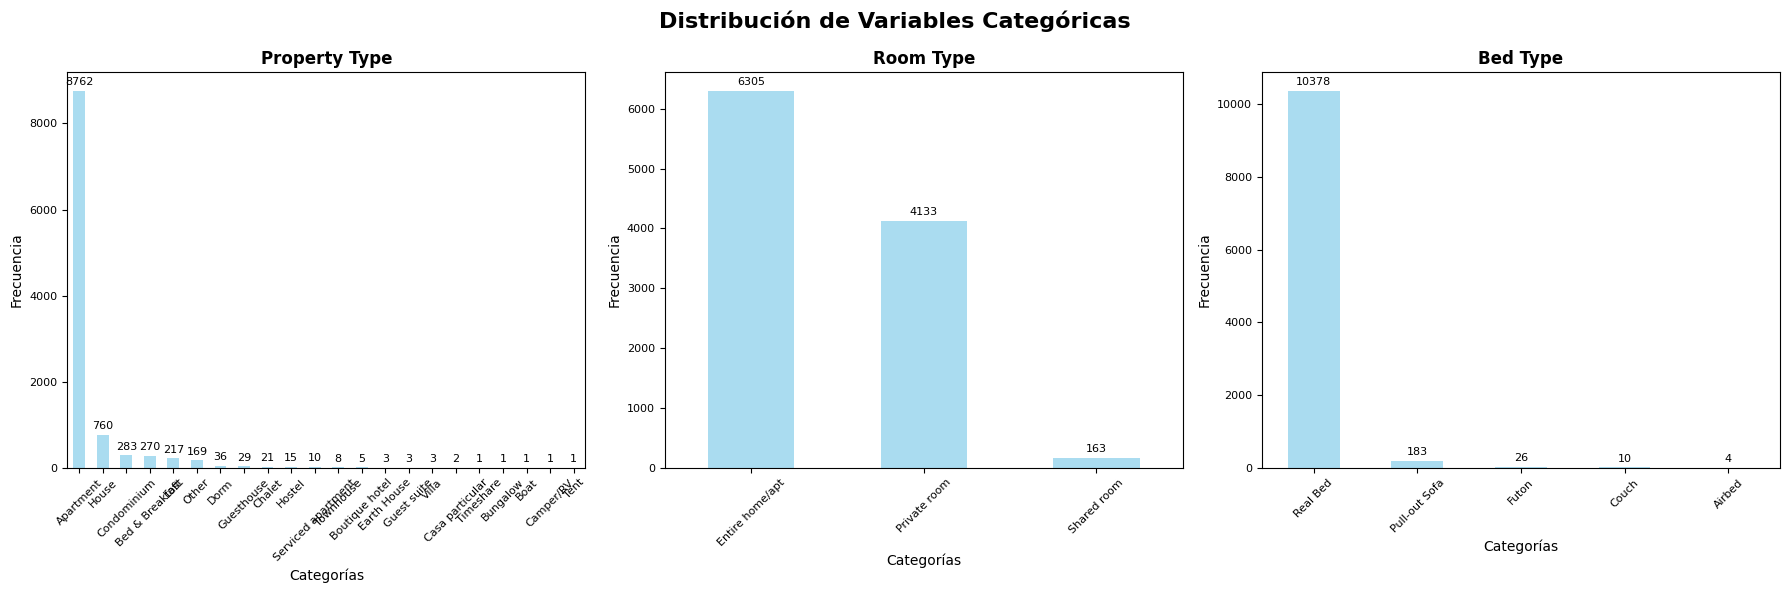

In [300]:
# Análisis de Property Type, Room Type, Bed Type con histogramas
import matplotlib.pyplot as plt
import seaborn as sns

variables_categoricas = ['Property Type', 'Room Type', 'Bed Type']

# Configurar el estilo de los gráficos
plt.style.use('default')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Distribución de Variables Categóricas', fontsize=16, fontweight='bold')

for i, var in enumerate(variables_categoricas):
    print(f"\n{'='*50}")
    print(f"ANÁLISIS DE {var.upper()}")
    print(f"{'='*50}")
    
    # Valores únicos
    valores_unicos = pretrain_data[var].nunique()
    print(f"Valores únicos: {valores_unicos}")
    
    # Distribución de frecuencias
    print(f"\nDistribución de frecuencias:")
    distribucion = pretrain_data[var].value_counts()
    print(distribucion)
    
    # Crear histograma
    ax = axes[i]
    distribucion.plot(kind='bar', ax=ax, color='skyblue', alpha=0.7)
    ax.set_title(f'{var}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Categorías', fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    # Añadir valores en las barras
    for j, v in enumerate(distribucion.values):
        ax.text(j, v + max(distribucion.values) * 0.01, str(v), 
                ha='center', va='bottom', fontsize=8)
    
    print(f"\n" + "-"*50)

plt.tight_layout()
plt.show()

Por valores únicos, puede tener sentido `Room Type`, hacer un one-hot encoding entre las 3 (apartamento entero, habitación privada o hab. compartida)
Por cantidad de valores mayoritarios, tiene sentido tratat `Bed type` como is_real_bed o no y agruparlo todo en dos categorias.
`Property Type`podría eliminarla por tener 22 caterg diferentes y estar muy balanceada.

### 3.2.1 Resumen tratamiento variables categoricas

Var categoricas:

| Atributo | descripción | conclusión |
|:---------|:------------|:-----------|
| *Experiences Offered* | experiencias adicionales al piso | Eliminar |
| *Host Since* | fecha registro del anfitrión en Airbnb | trasnformar a antigüedad en días --> imputar nulos = mediana|
| *ZipCode* | código barras | Standby |
| *Property Type* | tipo de propiedad | Eliminar |
| *Room Type* | tipo de habitación | One-Hot Encoding |
| *Bed Type* | tipo de cama | Var binaria is_Real Bed |
| *Amenities* | comodidades adicionales | Standby |
| *First Review* | fecha primera reseña | Eliminar |
| *Last Review* | fecha última reseña | Eliminar |

## 4. Preprocesado datos Train
#### Proceso datos de train en función de las conclusiones estadisticas
- Imputación de valores ausentes
- Codificación variables categoricas
- (Eliminación por random forest/Lasso, muchos Nan, alta correlación..)
- (Generación y transformación de variables)
- (Filtrado outliers)

In [523]:
#hago una copia para las trasnformaciones en Train
pretrain_data_procesado=pretrain_data.copy()

`Price` Eliminar nulos, filtrar outliers y transfo log1p

In [524]:
# Eliminar nulos en Price
pretrain_data_procesado = pretrain_data.dropna(subset=['Price'])

# Filtrar outliers
pretrain_data_procesado = pretrain_data_procesado[pretrain_data_procesado['Price'] <= 300]
datos_filtrados = len(pretrain_data_procesado)

print(f"Datos originales: {len(pretrain_data):,}")
print(f"Datos después filtro: {datos_filtrados:,}")
print(f"Datos eliminados: {len(pretrain_data) - datos_filtrados:,} ({((len(pretrain_data) - datos_filtrados)/len(pretrain_data))*100:.2f}%)")

Datos originales: 10,601
Datos después filtro: 10,509
Datos eliminados: 92 (0.87%)


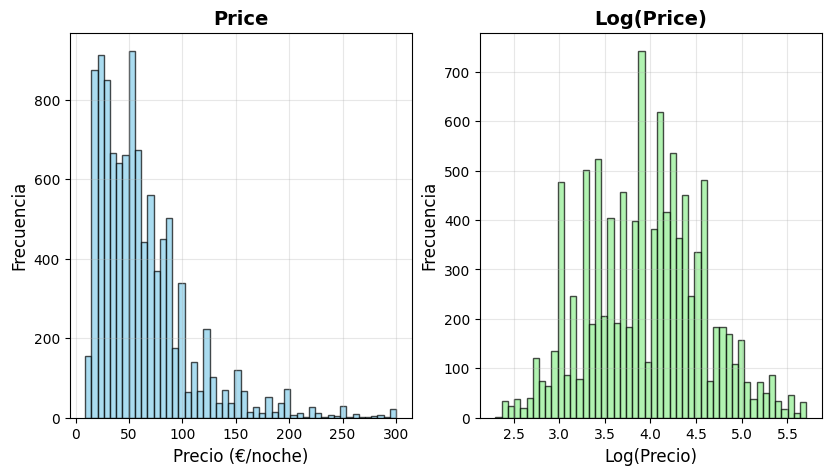

In [525]:
# Crear nueva variable con logaritmo del precio
pretrain_data_procesado['Price_Log'] = np.log1p(pretrain_data_procesado['Price'])  # log1p = log(1+x) para evitar log(0)

plt.figure(figsize=(15, 5))

# Original
plt.subplot(1, 3, 1)
plt.hist(pretrain_data_procesado['Price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Precio (€/noche)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Price', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Logarítmica
plt.subplot(1, 3, 2)
plt.hist(pretrain_data_procesado['Price_Log'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Log(Precio)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Log(Price)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

`Listing Count` quedarme con una y transfo log1p

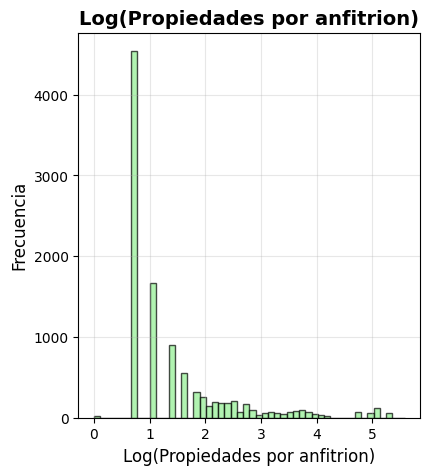

In [526]:
# Imputar valores nulos de Host Listings Count con la mediana antes de la transformación logarítmica
pretrain_data_procesado['Host Listings Count'] = pretrain_data_procesado['Host Listings Count'].fillna(pretrain_data_procesado['Host Listings Count'].median())

# Crear nueva variable con logaritmo del listings count
pretrain_data_procesado['Host Listings Count_Log'] = np.log1p(pretrain_data_procesado['Host Listings Count'])  

plt.figure(figsize=(15, 5))

# Logarítmica
plt.subplot(1, 3, 2)
plt.hist(pretrain_data_procesado['Host Listings Count_Log'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.xlabel('Log(Propiedades por anfitrion)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Log(Propiedades por anfitrion)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

`Beds`, `Bathrooms`, `Bedrooms` imputar nulos con la moda (garantizar valores enteros)

In [527]:
# Imputar valores nulos de Bathrooms, bedrooms y beds con la mediana
pretrain_data_procesado['Bathrooms'] = pretrain_data_procesado['Bathrooms'].fillna(pretrain_data_procesado['Bathrooms'].mode()[0])
pretrain_data_procesado['Bedrooms'] = pretrain_data_procesado['Bedrooms'].fillna(pretrain_data_procesado['Bedrooms'].mode()[0])
pretrain_data_procesado['Beds'] = pretrain_data_procesado['Beds'].fillna(pretrain_data_procesado['Beds'].mode()[0])

`Security Deposit`, `Cleaning Fee`, `Extra People`, `Reviews Per Month`  imputar nulos con 0 y transformar   `Minimum nights` transformar

In [528]:
# Imputar valores nulos con 0
pretrain_data_procesado['Security Deposit'].fillna(0, inplace=True)
pretrain_data_procesado['Cleaning Fee'].fillna(0, inplace=True)
pretrain_data_procesado['Extra People'].fillna(0, inplace=True)
pretrain_data_procesado['Reviews per Month'].fillna(0, inplace=True)

#Aplicar transformación 
# Crear nueva variable con logaritmo 
pretrain_data_procesado['Security Deposit_Log'] = np.log1p(pretrain_data_procesado['Security Deposit'])  
pretrain_data_procesado['Cleaning Fee_Log'] = np.log1p(pretrain_data_procesado['Cleaning Fee'])
pretrain_data_procesado['Extra People_Log'] = np.log1p(pretrain_data_procesado['Extra People'])  
pretrain_data_procesado['Minimum Nights_Log'] = np.log1p(pretrain_data_procesado['Minimum Nights'])  
pretrain_data_procesado['Reviews per Month_Log'] = np.log1p(pretrain_data_procesado['Reviews per Month'])   

`Booking Rate`, variable de `Availability 365`

In [529]:
pretrain_data_procesado['Booking Rate'] = (365- pretrain_data_procesado['Availability 365'])/365

`Avg Review Score`, variable de media de revisiones `Review Scores...`

In [530]:
review_score_columns = [
    'Review Scores Rating',
    'Review Scores Accuracy',
    'Review Scores Cleanliness',
    'Review Scores Checkin',
    'Review Scores Communication',
    'Review Scores Location',
    'Review Scores Value'
]

# Imputar los valores nulos con la mediana de cada columna 
for col in review_score_columns:
    median_value =pretrain_data_procesado[col].median()
    pretrain_data_procesado[col].fillna(median_value, inplace=True)

print("Valores nulos después de la imputación:")
print(pretrain_data_procesado[review_score_columns].isnull().sum())

Valores nulos después de la imputación:
Review Scores Rating           0
Review Scores Accuracy         0
Review Scores Cleanliness      0
Review Scores Checkin          0
Review Scores Communication    0
Review Scores Location         0
Review Scores Value            0
dtype: int64


In [531]:
# Crear una copia temporal para no modificar la original antes del cálculo
df_temp_scores = pretrain_data_procesado[review_score_columns].copy()

# Estandarizar 'Review Scores Rating'
df_temp_scores['Review Scores Rating'] = df_temp_scores['Review Scores Rating'] / 10

# Verificamos los rangos para asegurarnos de que la escala es correcta
print("\nValores máximos después de estandarizar 'rating':")
print(df_temp_scores.max())


Valores máximos después de estandarizar 'rating':
Review Scores Rating           10.0
Review Scores Accuracy         10.0
Review Scores Cleanliness      10.0
Review Scores Checkin          10.0
Review Scores Communication    10.0
Review Scores Location         10.0
Review Scores Value            10.0
dtype: float64


In [532]:
# Calcular la media de todas las columnas de puntuación para cada fila (axis=1)
pretrain_data_procesado['Avg Review Scores'] = df_temp_scores.mean(axis=1)

# Verificamos el resultado
print("\nPrimeras 5 filas con la nueva columna 'avg_review_score':")
print(pretrain_data_procesado[['Avg Review Scores'] + review_score_columns].head())


Primeras 5 filas con la nueva columna 'avg_review_score':
   Avg Review Scores  Review Scores Rating  Review Scores Accuracy  \
0           8.757143                  83.0                     9.0   
1           8.500000                  75.0                     9.0   
2           9.414286                  89.0                     9.0   
3           9.000000                  80.0                     8.0   
4           9.814286                  97.0                    10.0   

   Review Scores Cleanliness  Review Scores Checkin  \
0                        8.0                    9.0   
1                        9.0                    9.0   
2                        9.0                   10.0   
3                       10.0                   10.0   
4                       10.0                   10.0   

   Review Scores Communication  Review Scores Location  Review Scores Value  
0                          9.0                     9.0                  9.0  
1                          8.0   

`Host since`la transformamos a antiguedad de anfitrion en registro:

In [533]:
# Host Since: imputar nulos y crear variable días
pretrain_data_procesado['Host Since'] = pd.to_datetime(pretrain_data_procesado['Host Since'], errors='coerce')
pretrain_data_procesado['Host Since'].fillna(pretrain_data_procesado['Host Since'].median(), inplace=True)

# Crear Host Since Days (antigüedad en días desde 7/04/2017)
fecha_ref = pd.to_datetime('2017-04-07')
pretrain_data_procesado['Host Since Days'] = (fecha_ref - pretrain_data_procesado['Host Since']).dt.days

print(f"Host Since Days - Min: {pretrain_data_procesado['Host Since Days'].min()}, Max: {pretrain_data_procesado['Host Since Days'].max()}")

Host Since Days - Min: 0, Max: 2882


`Room Type` One-Hot Encoding a los 3 categorias. 

In [534]:
pretrain_data_procesado = pd.get_dummies(pretrain_data_procesado, columns=['Room Type'], prefix='room', dtype=int)

`Bed type` la convertimos en una variable que indique si hay o no una cama Real

In [535]:
pretrain_data_procesado['is_real_bed'] = (pretrain_data_procesado['Bed Type'] == 'Real Bed').astype(int)

`First Review`, `Last Review` Voya usar la diferencia en días para tratarla como númerica (y sacar la frecuencia de revisones conjunto a `Number of reviews`más adelante)

In [536]:
import pandas as pd

# Convertir a datetime
pretrain_data_procesado['First Review'] = pd.to_datetime(pretrain_data_procesado['First Review'], errors='coerce')
pretrain_data_procesado['Last Review'] = pd.to_datetime(pretrain_data_procesado['Last Review'], errors='coerce')

# Calcular diferencia en días
pretrain_data_procesado['Review_Days_Diff'] = (pretrain_data_procesado['Last Review'] - pretrain_data_procesado['First Review']).dt.days

# Rellenar valores nulos con 0 y aseguro que no haya valores negativos
pretrain_data_procesado['Review_Days_Diff'] = pretrain_data_procesado['Review_Days_Diff'].fillna(0)
pretrain_data_procesado['Review_Days_Diff'] = pretrain_data_procesado['Review_Days_Diff'].clip(lower=0)

# Nueva columna
print(f"Nueva columna 'Review_Days_Diff' creada:")
print(f"Tipo de datos: {pretrain_data_procesado['Review_Days_Diff'].dtype}")
print(f"Valores únicos: {pretrain_data_procesado['Review_Days_Diff'].nunique()}")

print(pretrain_data_procesado['Review_Days_Diff'].describe())

# Mostrar algunos ejemplos
print(f"\nPrimeros 10 valores:")
print(pretrain_data_procesado[['First Review', 'Last Review', 'Review_Days_Diff']].head(5))

Nueva columna 'Review_Days_Diff' creada:
Tipo de datos: float64
Valores únicos: 1494
count    10509.000000
mean       323.732325
std        410.427696
min          0.000000
25%          0.000000
50%        169.000000
75%        497.000000
max       2519.000000
Name: Review_Days_Diff, dtype: float64

Primeros 10 valores:
  First Review Last Review  Review_Days_Diff
0   2013-10-08  2016-09-19            1077.0
1   2016-05-16  2016-08-19              95.0
2   2014-08-11  2017-03-19             951.0
3   2016-10-26  2016-10-30               4.0
4   2015-03-15  2017-03-31             747.0


- `Host Acceptance Rate`, `Has Availability`: puedo eliminarlas porque todos son valores nulos 

- `First Review`, `Last Review`: puedo eliminarlas porque las transforme en `Review_Days_Diff`

- `Zipcode`, `Amenities`,`Propierty Type`: las elimino y no la voy a incluir de momento

In [537]:
#...y la coloco la primera
price_col = pretrain_data_procesado['Price_Log']
pretrain_data_procesado = pretrain_data_procesado.drop('Price_Log', axis=1)
pretrain_data_procesado.insert(0, 'Price_Log', price_col)


# Eliminar columnas especificadas del dataset pretrain_data
columns_to_remove = [
    'Price', 'Host Response Rate', 'Host Acceptance Rate', 'Host Listings Count', 'Host Total Listings Count', 
    'Square Feet', 'Weekly Price', 'Monthly Price', 'Security Deposit', 'Cleaning Fee', 'Extra People',
    'Minimum Nights', 'Maximum Nights', 'Has Availability', 'Availability 30', 'Availability 60', 'Availability 90',
    'Availability 365', 'Reviews per Month', 'Review Scores Rating','Review Scores Accuracy','Review Scores Cleanliness',
    'Review Scores Checkin','Review Scores Communication','Review Scores Location','Review Scores Value',
    'Calculated host listings count', 'Experiences Offered', 'Host Since', 'Zipcode', 'Property Type', 'Bed Type','Amenities', 
    'First Review', 'Last Review'
]

# Eliminar las columnas existentes
pretrain_data_procesado = pretrain_data_procesado.drop(columns=columns_to_remove)

print(f"\nDataset original: {pretrain_data.shape}")
print(f"Dataset después de eliminar columnas: {pretrain_data_procesado.shape}")
print(f"Columnas eliminadas: {len(columns_to_remove)}")

# Mostrar las primeras filas del dataset limpio
pretrain_data_procesado.head().T


Dataset original: (10601, 44)
Dataset después de eliminar columnas: (10509, 23)
Columnas eliminadas: 35


,0,1,2,3,4
Price_Log,3.713572,2.944439,4.094345,2.995732,4.317488
Latitude,40.424541,40.435688,40.413167,40.407085,40.420483
Longitude,-3.711495,-3.671686,-3.708769,-3.607053,-3.703334
Accommodates,2.000000,2.000000,2.000000,1.000000,4.000000
Bathrooms,1.000000,1.000000,1.000000,1.000000,1.000000
Bedrooms,1.000000,1.000000,1.000000,1.000000,1.000000
Beds,1.000000,2.000000,1.000000,1.000000,2.000000
Guests Included,1.000000,1.000000,1.000000,1.000000,2.000000
Number of Reviews,26.000000,8.000000,51.000000,3.000000,109.000000
Host Listings Count_Log,1.098612,1.609438,0.693147,0.693147,1.098612


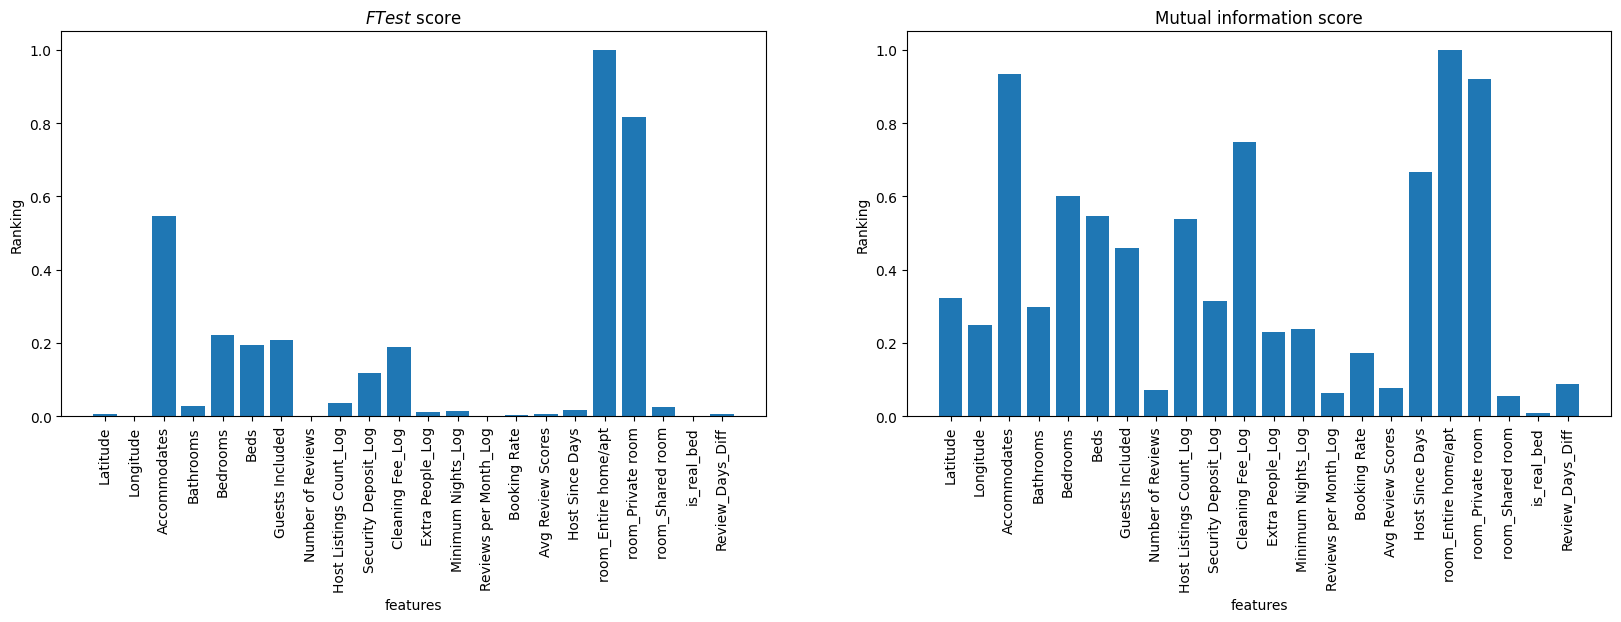

In [538]:
from sklearn.feature_selection import f_regression, mutual_info_regression

# convertimos el DataFrame al formato necesario para scikit-learn
data = pretrain_data_procesado.values

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names_mi = pretrain_data_procesado.columns[1:]

# estudiamos los dos métodos de filtrado
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# visualización
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names_mi, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names_mi, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

## 5. Procesado datos Test
#### Aplico las mismas transformaciones que en Train

RESUMEN TRANSFORMACIONES EN TRAIN

In [ ]:
#CARGO DATOS TRAIN
pretrain_data = pd.read_csv('airbnb-listings-extract-train.csv', sep=';', decimal='.')

#COPIA PARA APLICAR LAS TRANSFORMACIONES
pretrain_data_procesado = pretrain_data.copy()

#VAR PRICE
pretrain_data_procesado = pretrain_data_procesado.dropna(subset=['Price'])
pretrain_data_procesado = pretrain_data_procesado[pretrain_data_procesado['Price'] <= 300]
pretrain_data_procesado['Price_Log'] = np.log1p(pretrain_data_procesado['Price']) 
#...y la coloco la primera
price_col = pretrain_data_procesado['Price_Log']
pretrain_data_procesado = pretrain_data_procesado.drop('Price_Log', axis=1)
pretrain_data_procesado.insert(0, 'Price_Log', price_col)

#IMPUTACION NULOS CON MEDIANA
columns_to_impute_median = ['Host Listings Count', 'Bathrooms', 'Bedrooms', 'Beds']
for col in columns_to_impute_median:
    pretrain_data_procesado[col] = pretrain_data_procesado[col].fillna(pretrain_data_procesado[col].mode()[0])

#IMPUTACION NULOS CON 0
columns_to_impute_zero = ['Security Deposit', 'Cleaning Fee', 'Extra People', 'Reviews per Month']
for col in columns_to_impute_zero:
    pretrain_data_procesado[col].fillna(0, inplace=True)

#TRANSFORMACION LOG VARIABLES
columns_to_log_transform = [
    'Host Listings Count', 'Security Deposit', 'Cleaning Fee', 
    'Extra People', 'Minimum Nights', 'Reviews per Month']
for col in columns_to_log_transform:
    pretrain_data_procesado[f'{col}_Log'] = np.log1p(pretrain_data_procesado[col])

#VAR BOOKING RATE
pretrain_data_procesado['Booking Rate'] = (365- pretrain_data_procesado['Availability 365'])/365

#VAR HOST SINCE DAYS
pretrain_data_procesado['Host Since'] = pd.to_datetime(pretrain_data_procesado['Host Since'], errors='coerce')
pretrain_data_procesado['Host Since'].fillna(pretrain_data_procesado['Host Since'].median(), inplace=True)
fecha_ref = pd.to_datetime('2017-04-07')
pretrain_data_procesado['Host Since Days'] = (fecha_ref - pretrain_data_procesado['Host Since']).dt.days

#VAR AVG REVIEW
review_score_columns = [
    'Review Scores Rating',
    'Review Scores Accuracy',
    'Review Scores Cleanliness',
    'Review Scores Checkin',
    'Review Scores Communication',
    'Review Scores Location',
    'Review Scores Value'
]
for col in review_score_columns:
    median_value = pretrain_data_procesado[col].median()
    pretrain_data_procesado[col].fillna(median_value, inplace=True)

pretrain_data_procesado['Review Scores Rating'] = pretrain_data_procesado['Review Scores Rating'] / 10
pretrain_data_procesado['Avg Review Scores'] = pretrain_data_procesado[review_score_columns].mean(axis=1)

#CODIFICACION CATEGORICAS

#VAR A ELIMINAR
columns_to_remove = [
    'Price', 'Host Response Rate', 'Host Acceptance Rate', 'Host Listings Count', 'Host Total Listings Count', 
    'Square Feet', 'Weekly Price', 'Monthly Price', 'Security Deposit', 'Cleaning Fee', 'Extra People',
    'Minimum Nights', 'Maximum Nights', 'Has Availability', 'Availability 30', 'Availability 60', 'Availability 90',
    'Availability 365', 'Reviews per Month', 'Review Scores Rating','Review Scores Accuracy','Review Scores Cleanliness',
    'Review Scores Checkin','Review Scores Communication','Review Scores Location','Review Scores Value',
    'Calculated host listings count',
    'Experiences Offered', 'Host Since', 'Zipcode', 'Property Type', 
    'Room Type', 'Bed Type','Amenities', 'First Review', 'Last Review'
]

# Filtrar solo las columnas que existen
columns_to_remove = [col for col in columns_to_remove if col in pretrain_data_procesado.columns]
pretrain_data_final = pretrain_data_procesado.drop(columns=columns_to_remove)

In [368]:
pretrain_data_final.shape

(10509, 18)

In [369]:
pretrain_data_final.head(5).T

,0,1,2,3,4
Price_Log,3.713572,2.944439,4.094345,2.995732,4.317488
Latitude,40.424541,40.435688,40.413167,40.407085,40.420483
Longitude,-3.711495,-3.671686,-3.708769,-3.607053,-3.703334
Accommodates,2.000000,2.000000,2.000000,1.000000,4.000000
Bathrooms,1.000000,1.000000,1.000000,1.000000,1.000000
Bedrooms,1.000000,1.000000,1.000000,1.000000,1.000000
Beds,1.000000,2.000000,1.000000,1.000000,2.000000
Guests Included,1.000000,1.000000,1.000000,1.000000,2.000000
Number of Reviews,26.000000,8.000000,51.000000,3.000000,109.000000
Host Listings Count_Log,1.098612,1.609438,0.693147,0.693147,1.098612


In [370]:
pretrain_data_final.describe().T

,count,mean,std,min,25%,50%,75%,max
Price_Log,10509.0,3.956732,0.630214,2.302585,3.433987,3.951244,4.394449,5.707110
Latitude,10509.0,40.420510,0.020205,40.331888,40.409999,40.418579,40.427831,40.514247
Longitude,10509.0,-3.697154,0.023620,-3.835498,-3.707781,-3.701552,-3.693876,-3.573613
Accommodates,10509.0,3.153012,1.922062,1.000000,2.000000,2.000000,4.000000,16.000000
Bathrooms,10472.0,1.243745,0.580711,0.000000,1.000000,1.000000,1.000000,8.000000
Bedrooms,10496.0,1.275248,0.783696,0.000000,1.000000,1.000000,1.000000,10.000000
Beds,10472.0,1.959798,1.457319,1.000000,1.000000,1.000000,2.000000,16.000000
Guests Included,10509.0,1.562756,1.043125,1.000000,1.000000,1.000000,2.000000,16.000000
Number of Reviews,10509.0,23.252736,38.472016,0.000000,1.000000,8.000000,28.000000,389.000000
Host Listings Count_Log,10507.0,1.450839,1.040332,0.000000,0.693147,1.098612,1.791759,5.583496


APLICO A TEST IGUAL

In [376]:
#CARGO DATOS TEST
pretest_data = pd.read_csv('airbnb-listings-extract-test.csv', sep=';', decimal='.') #Test de sólo madrid sin columnas texto

In [ ]:
#COPIA PARA APLICAR LAS TRANSFORMACIONES
pretest_data_procesado = pretest_data.copy()

#VAR PRICE
pretest_data_procesado = pretest_data_procesado.dropna(subset=['Price'])
pretest_data_procesado = pretest_data_procesado[pretest_data_procesado['Price'] <= 300]
pretest_data_procesado['Price_Log'] = np.log1p(pretest_data_procesado['Price']) 
#...y la coloco la primera
price_col = pretest_data_procesado['Price_Log']
pretest_data_procesado = pretest_data_procesado.drop('Price_Log', axis=1)
pretest_data_procesado.insert(0, 'Price_Log', price_col)

#IMPUTACION NULOS CON MEDIANA - LA DE TRAIN
columns_to_impute_median = ['Host Listings Count', 'Bathrooms', 'Bedrooms', 'Beds']
for col in columns_to_impute_median:
    pretest_data_procesado[col] = pretest_data_procesado[col].fillna(pretrain_data_procesado[col].mode()[0])

#IMPUTACION NULOS CON 0
columns_to_impute_zero = ['Security Deposit', 'Cleaning Fee', 'Extra People', 'Reviews per Month']
for col in columns_to_impute_zero:
    pretest_data_procesado[col].fillna(0, inplace=True)

#TRANSFORMACION LOG VARIABLES
columns_to_log_transform = [
    'Host Listings Count', 'Security Deposit', 'Cleaning Fee', 
    'Extra People', 'Minimum Nights', 'Reviews per Month']
for col in columns_to_log_transform:
    pretest_data_procesado[f'{col}_Log'] = np.log1p(pretest_data_procesado[col])

#VAR BOOKING RATE
pretest_data_procesado['Booking Rate'] = (365- pretest_data_procesado['Availability 365'])/365

#VAR HOST SINCE DAYS
pretest_data_procesado['Host Since'] = pd.to_datetime(pretest_data_procesado['Host Since'], errors='coerce')
pretest_data_procesado['Host Since'].fillna(pretrain_data_procesado['Host Since'].median(), inplace=True)
fecha_ref = pd.to_datetime('2017-04-07')
pretest_data_procesado['Host Since Days'] = (fecha_ref - pretest_data_procesado['Host Since']).dt.days

#VAR AVG REVIEW
review_score_columns = [
    'Review Scores Rating',
    'Review Scores Accuracy',
    'Review Scores Cleanliness',
    'Review Scores Checkin',
    'Review Scores Communication',
    'Review Scores Location',
    'Review Scores Value'
]
for col in review_score_columns:
    median_value = pretrain_data_procesado[col].median()
    pretest_data_procesado[col].fillna(median_value, inplace=True)

pretest_data_procesado['Review Scores Rating'] = pretest_data_procesado['Review Scores Rating'] / 10
pretest_data_procesado['Avg Review Scores'] = pretest_data_procesado[review_score_columns].mean(axis=1)

#VAR A ELIMINAR
columns_to_remove = [
    'Price', 'Host Response Rate', 'Host Acceptance Rate', 'Host Listings Count', 'Host Total Listings Count', 
    'Square Feet', 'Weekly Price', 'Monthly Price', 'Security Deposit', 'Cleaning Fee', 'Extra People',
    'Minimum Nights', 'Maximum Nights', 'Has Availability', 'Availability 30', 'Availability 60', 'Availability 90',
    'Availability 365', 'Reviews per Month', 'Review Scores Rating','Review Scores Accuracy','Review Scores Cleanliness',
    'Review Scores Checkin','Review Scores Communication','Review Scores Location','Review Scores Value',
    'Calculated host listings count',
    'Experiences Offered', 'Host Since', 'Zipcode', 'Property Type', 
    'Room Type', 'Bed Type','Amenities', 'First Review', 'Last Review'
]

# Filtrar solo las columnas que existen
columns_to_remove = [col for col in columns_to_remove if col in pretest_data_procesado.columns]
pretest_data_final = pretest_data_procesado.drop(columns=columns_to_remove)

In [373]:
pretest_data_final.describe().T

,count,mean,std,min,25%,50%,75%,max
Price_Log,2634.0,3.969908,0.629249,2.397895,3.465736,3.970292,4.394449,5.707110
Latitude,2634.0,40.420506,0.019930,40.332908,40.410006,40.418465,40.427674,40.562736
Longitude,2634.0,-3.697332,0.023409,-3.863907,-3.707895,-3.701886,-3.693730,-3.576484
Accommodates,2634.0,3.158694,1.903848,1.000000,2.000000,2.000000,4.000000,16.000000
Bathrooms,2634.0,1.224563,0.539697,0.000000,1.000000,1.000000,1.000000,6.000000
Bedrooms,2634.0,1.288535,0.798953,0.000000,1.000000,1.000000,2.000000,10.000000
Beds,2634.0,1.941154,1.364723,1.000000,1.000000,2.000000,2.000000,16.000000
Guests Included,2634.0,1.580866,1.081080,1.000000,1.000000,1.000000,2.000000,10.000000
Number of Reviews,2634.0,23.088079,38.958018,0.000000,1.000000,7.000000,26.000000,446.000000
Host Listings Count_Log,2634.0,1.441453,1.030539,0.000000,0.693147,1.098612,1.791759,5.337538


## 6. Preparacion dataset Train / Test
#### Preparamos el dataset

In [378]:
from sklearn import preprocessing

# Dataset de train
data_train = pretrain_data_final.values
y_train = data_train[:,0:1]     # nos quedamos con la 1ª columna, price_log
X_train = data_train[:,1:]      # nos quedamos con el resto

# Dataset de test
data_test = pretest_data_final.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price_log
X_test = data_test[:,1:]      # nos quedamos con el resto

#### Normalizo Test con los datos de Train

In [360]:
# Escalo con los datos de train
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

# Escalo test con los datos de train 
XtestScaled = scaler.transform(X_test) 

In [328]:
print('Datos entrenamiento: ', XtrainScaled.shape)
print('Datos test: ', XtestScaled.shape)

Datos entrenamiento:  (10509, 17)
Datos test:  (2634, 17)


## 7. Modelado
### 7.1 LASSO+CV
#### Cross validation con búsqueda de parámetros óptimos 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-3,2,20)
param_grid = {'alpha': alpha_vector }

# 5-fold CV para mejor estimación y menos sesgo
grid = GridSearchCV(Lasso(), scoring='neg_mean_squared_error', param_grid=param_grid, cv=5, verbose=2)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#-1 porque es negado
scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('5-Fold MSE')  
plt.show()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................alpha=0.0018329807108324356; total time=   0.0s
[CV] END ........................alpha=0.0018329807108324356; total time=   0.0s
[CV] END ........................alpha=0.0018329807108324356; total time=   0.0s
[CV] END ........................alpha=0.0018329807108324356; total time=   0.0s
[CV] END ........................alpha=0.0018329807108324356; total time=   0.0s
[CV] END .........................alpha=0.003359818286283781; total time=   0.0s
[CV] END .........................alpha=0.00335

ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/keepcoding-ml/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/anaconda3/envs/keepcoding-ml/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/anaconda3/envs/keepcoding-ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py", line 982, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/anaconda3/envs/keepcoding-ml/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/anaconda3/envs/keepcoding-ml/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/anaconda3/envs/keepcoding-ml/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1107, in check_array
    _assert_all_finite(
  File "/usr/local/anaconda3/envs/keepcoding-ml/lib/python3.12/site-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/usr/local/anaconda3/envs/keepcoding-ml/lib/python3.12/site-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
Lasso does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


El modelo alcanza el mejor rendimiento (aprox. 0.196) en valores de alpha entre 10^-3. A partir de 10^-2 empieza a aumentar drásticamente

#### Evaluacion LASSO

In [330]:
alpha_optimo = grid.best_params_['alpha']
print(alpha_optimo)

0.001


In [331]:
from sklearn.metrics import mean_squared_error

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

feature_names = pretrain_data_final.columns[1:] # es igual en train y en test

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 0.195
MSE Modelo Lasso (test) : 0.207
RMSE Modelo Lasso (train): 0.442
RMSE Modelo Lasso (test) : 0.455
Latitude 0.05600137542850446
Longitude -0.011538894539362701
Accommodates 0.4035183708742037
Bathrooms -0.016815721650039077
Bedrooms 0.05060159236236228
Beds -0.12870601590611938
Guests Included 0.07625896810842288
Number of Reviews 0.01214949198660976
Host Listings Count_Log 0.01926413863059925
Security Deposit_Log 0.05551782486368457
Cleaning Fee_Log 0.10666573366864658
Extra People_Log -0.11344238239241246
Minimum Nights_Log 0.0167689557418522
Reviews per Month_Log -0.04905597509624708
Booking Rate -0.025749960293582744
Host Since Days 0.0324380718365967
Avg Review Scores 0.07697173172625112


### En vista de los resultados podemos decir:
- El error de 0.455 se traduce en exp^0.455= 1.58, es decir, en promedio las predicciones se desvían un factor de 1.58. A groso modo, para un piso de 100€ el modelo predice en un rango de valores entre 63-158€ el 68% de las veces (media +- 1vez ds)
- El modelo tiene un error porcentual mas o menos constante para diferentes rangos de precios y eso es bueno (no es igual equivocarte en 20€ para un piso de 60€/noche que uno de 200€/noche)
- Que el modelo generaliza bien y no esta sobreajustado (Errores similares entre Train y test)
- Sobre los coeficientes, las variables que parecen tener más peso son Accommodates, Cleaning Fee, Extra people. Las que pparecen tener menos peso son: logitude (parece que no es muy relevante que este al este o al oeste), nº reviews (parece que impacta la media de la puntuación que el número en sí), la estancia minima (probablemente porque la mayoria tienen datos similares de 1-3 noches y los extermos no son tan fuertes) o el nºde propiedades del anfitrion. Quizá haya relaciones más complejas que no este teniendo en cuenta Lasso por lo que no convendría descartarlas sin analizar eesultado de otro tipo de modelos

### 7.2 RANDOM FOREST
#### Esperamos mejora del rendimiento porque el modelo capture relaciones no lineales más complejas que se escapen a Lasso.

### 7.3 GRADIENT BOOSTING

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [1000,1500,2000,2500,3000]
learningRate = [0.1,0.05,0.02]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 3, verbose=2,scoring='r2')
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=  19.9s
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=  23.9s
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=  24.1s
[CV] END ..............learning_rate=0.05, n_estimators=2000; total time=  32.5s
[CV] END ..............learning_rate=0.05, n_estimators=2000; total time=  32.3s
[CV] END ..............learning_rate=0.05, n_estimators=2000; total time=  30.0s
[CV] END ..............learning_rate=0.05, n_estimators=2500; total time=  37.6s
[CV] END ..............learning_rate=0.05, n_estimators=2500; total time=  39.8s
[CV] END ..............learning_rate=0.05, n_estimators=2500; total time=  38.2s
[CV] END ..............learning_rate=0.05, n_estimators=3000; total time=  47.6s
[CV] END ..............learning_rate=0.05, n_estimators=3000; total time=  47.5s
[CV] END ..............learning_rate=0.05, n_est

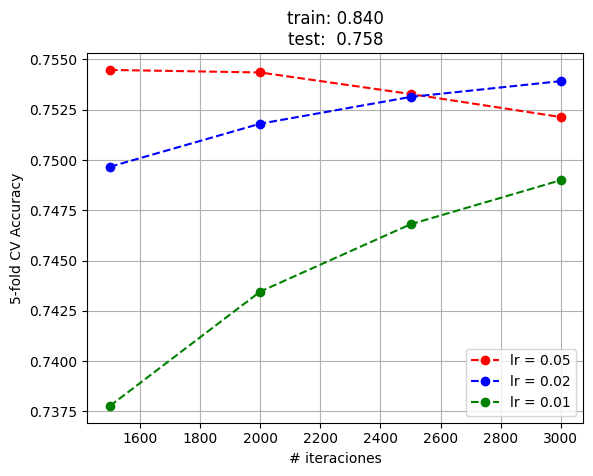

In [ ]:
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('3-fold CV Accuracy')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

- Con una tasa de aprendizaje de 0.1 el modelo mejora más rapido hasta las 1000 iteraciones pero luego cae drasticamente. Con una tasa de aprendizaje más baja de 0.05 el modelo aprende más lento pero es mejor (alcanza el pico de rend a las 1500 iteraciones). Esto nos da una pista de que menores tasas de aprendizaje y mayor numero de arboles podría ser donde se encuentren los parámetos optimos. Volvemoa a iterar bajando el umbral de lr y subiendo las iteraciones. Nos da que el resultado optimo sigue siendo el mismo que ya habiamos encontrado previamente (pero habia que explorar)

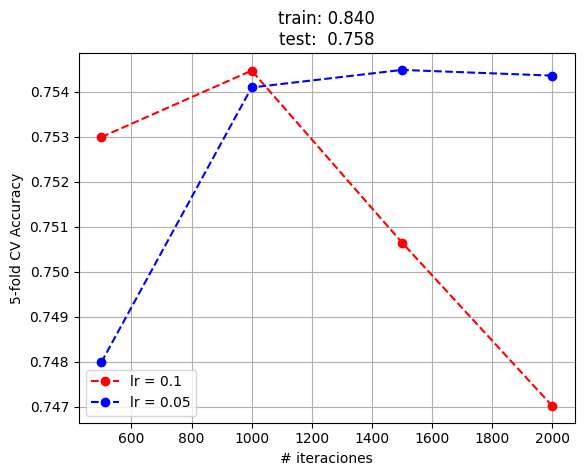

- Probamos como parametros lr=0.05, itera=1500 y max_depth=3 y tenemos un resultado de 0.84 Train y 0.76 Test, lo que significa que el modelo es capaz de explicar el 76% de la variabilidad de precios. Sin embargo, la diferencia entre train y test indica que hay overfitting y habría que corregirlo. 


In [390]:
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
baggingModel = GradientBoostingRegressor(max_depth=3, n_estimators=neOptimo, learning_rate=lrOptimo).fit(X_train,y_train)

print("Train: ",baggingModel.score(X_train,y_train))
print("Test: ",baggingModel.score(X_test,y_test))

Train:  0.839517356796478
Test:  0.7579725405510735


In [386]:
#RMSE en test
ytestGradientBoosting = baggingModel.predict(X_test)
rmseTestGradientBoosting = np.sqrt(mean_squared_error(y_test, ytestGradientBoosting))

print(f'RMSE Modelo Gradient Boosting (test): {rmseTestGradientBoosting:.3f}')

RMSE Modelo Gradient Boosting (test): 0.310


Comparando el RMSE de Lasso (0.455) con Gradient Boosting se ve como ha disminuido claramente el error de predicción. El factor pasa a 1.36 reduciendo el rango de incertidumbre predicción de precios. 

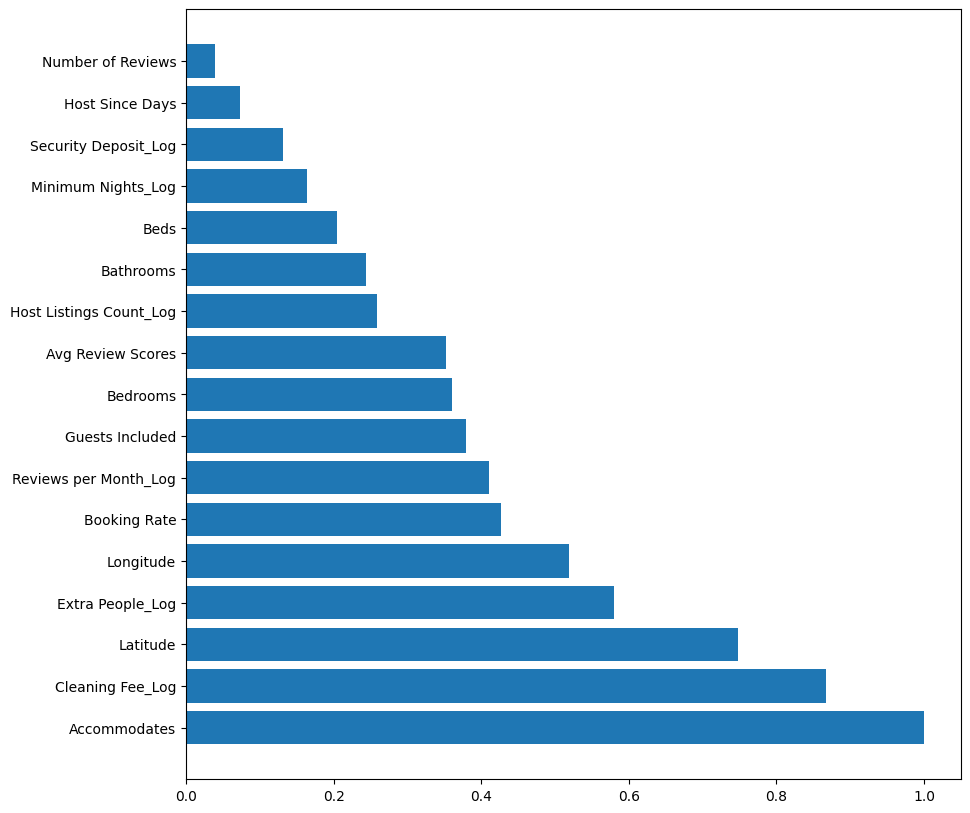

In [384]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

Se aprecia como var importantes Accommodates y Cleaning Fee (como ya se indicaba en Lasso). En este caso da más importacia a ambas coordenadas de ubicación (aunque Latitude con bastante más peso, lo cual tiene sentido-Norte/Sur)

### 7.4 XGBoost

In [391]:
!pip install xgboost

Usamos RandomizedSearchCV para hacer un primer barrido sobre los 3 parámetros (learning rate, iteraciones y max_depth)

In [436]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Búsqueda de parámetros óptimos XGBoost
Niterations = [1000,1500,2000,2500]
learningRate = [0.05, 0.02, 0.01]
maxDepth = [2,3,4]

param_grid_xgb = {'n_estimators': Niterations,'learning_rate':learningRate , 'max_depth':maxDepth}
xgb_model = xgb.XGBRegressor(random_state=0)
random = RandomizedSearchCV(xgb_model, param_distributions=param_grid_xgb, cv = 3, verbose=2, scoring='r2')
random.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(random.best_score_))
print("best parameters: {}".format(random.best_params_))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .learning_rate=0.05, max_depth=4, n_estimators=1000; total time=   0.7s
[CV] END .learning_rate=0.05, max_depth=4, n_estimators=1000; total time=   0.6s
[CV] END .learning_rate=0.05, max_depth=4, n_estimators=1000; total time=   0.6s
[CV] END .learning_rate=0.05, max_depth=3, n_estimators=1000; total time=   0.5s
[CV] END .learning_rate=0.05, max_depth=3, n_estimators=1000; total time=   0.5s
[CV] END .learning_rate=0.05, max_depth=3, n_estimators=1000; total time=   0.5s
[CV] END .learning_rate=0.01, max_depth=2, n_estimators=1000; total time=   0.3s
[CV] END .learning_rate=0.01, max_depth=2, n_estimators=1000; total time=   0.3s
[CV] END .learning_rate=0.01, max_depth=2, n_estimators=1000; total time=   0.3s
[CV] END .learning_rate=0.05, max_depth=2, n_estimators=1500; total time=   0.5s
[CV] END .learning_rate=0.05, max_depth=2, n_estimators=1500; total time=   1.0s
[CV] END .learning_rate=0.05, max_depth=2, n_est

Afino la búsqeuda de learning rate y el numero de arboles fijando la profundidad a 4.

In [435]:
# Búsqueda de parámetros óptimos XGBoost
Niterations = [500, 1000, 1500, 2000, 2500]
learningRate = [0.07,0.05, 0.02, 0.01]
# mantenemos max_depth estático: max_depth=4

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
xgb_model = xgb.XGBRegressor(random_state=0, max_depth=4)
grid = GridSearchCV(xgb_model, param_grid=param_grid, cv = 3, verbose=2,scoring='r2')
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ...............learning_rate=0.07, n_estimators=500; total time=   0.4s
[CV] END ...............learning_rate=0.07, n_estimators=500; total time=   0.3s
[CV] END ...............learning_rate=0.07, n_estimators=500; total time=   0.3s
[CV] END ..............learning_rate=0.07, n_estimators=1000; total time=   0.6s
[CV] END ..............learning_rate=0.07, n_estimators=1000; total time=   0.6s
[CV] END ..............learning_rate=0.07, n_estimators=1000; total time=   0.6s
[CV] END ..............learning_rate=0.07, n_estimators=1500; total time=   0.8s
[CV] END ..............learning_rate=0.07, n_estimators=1500; total time=   0.9s
[CV] END ..............learning_rate=0.07, n_estimators=1500; total time=   0.8s
[CV] END ..............learning_rate=0.07, n_estimators=2000; total time=   1.3s
[CV] END ..............learning_rate=0.07, n_estimators=2000; total time=   1.1s
[CV] END ..............learning_rate=0.07, n_est

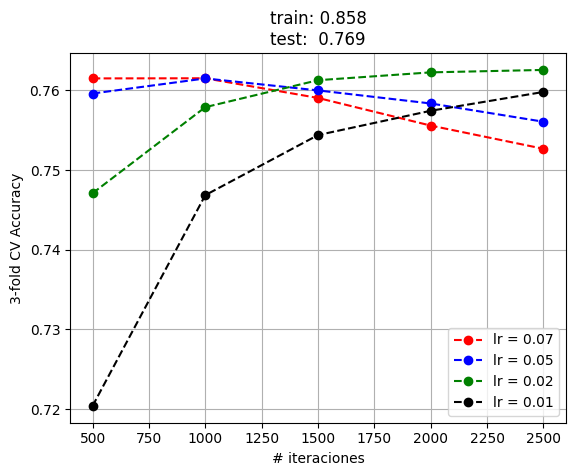

In [441]:
Niterations = [500, 1000, 1500, 2000, 2500]
learningRate = [0.07,0.05, 0.02, 0.01]

lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = xgb.XGBRegressor(random_state=0, max_depth=4,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('3-fold CV Accuracy')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

Si aumentamos la profundidad, aumenta el rendimiento en Train y en Test no aumenta tanto (0.927 y 0.776 para depth=7). Esto indica un claro sobreajuste. Si reducimos a 4 la profundidad encontramos un equilibrio de rend., bajar más no mejora el resultado en test.

In [443]:
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
XGBModel = xgb.XGBRegressor(max_depth=4, n_estimators=neOptimo, learning_rate=lrOptimo).fit(X_train,y_train)

print("Train: ",XGBModel.score(X_train,y_train))
print("Test: ",XGBModel.score(X_test,y_test))


Train:  0.8582449452847545
Test:  0.7689893402584489


In [444]:
#RMSE en test
y_pred_test_xgb = XGBModel.predict(X_test)
rmseTestXGBoosting = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))

print(f'RMSE Modelo Gradient Boosting (test): {rmseTestXGBoosting:.3f}')

RMSE Modelo Gradient Boosting (test): 0.302


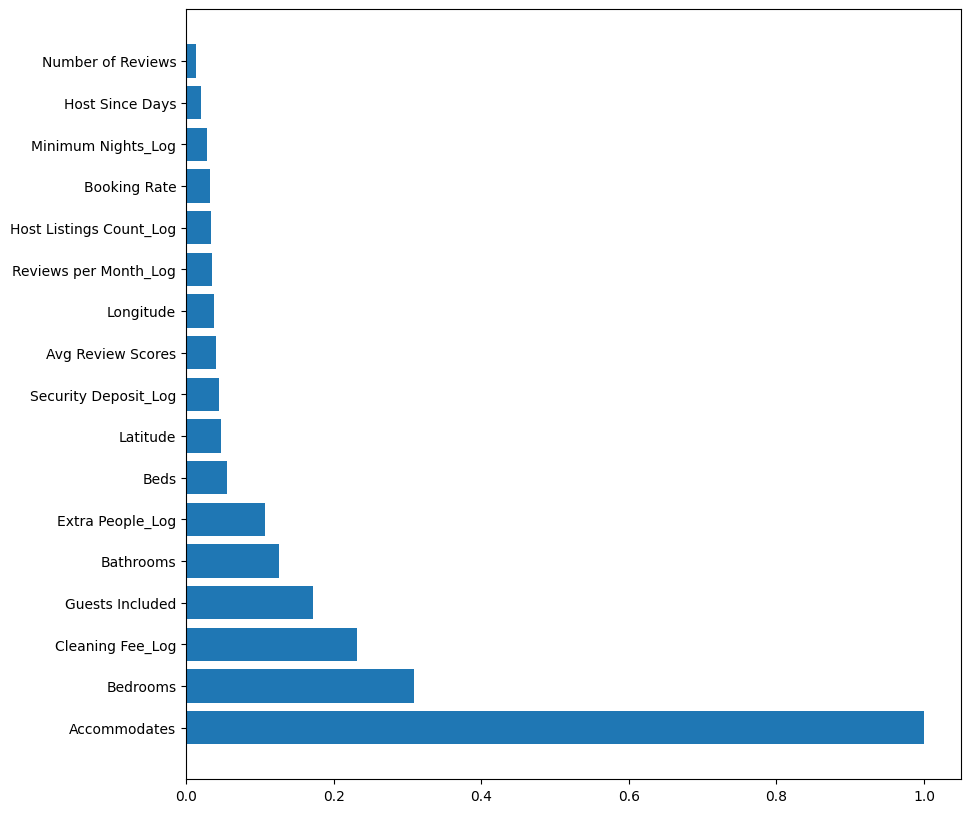

In [446]:
importances = XGBModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()